# Milestone One

## Introduction

#### Objective:

 - Given a pretrained GBM model and accompanying data, interpret the underlying logic of the model using SHAP.

#### Workflow:

 - Load data and model
 - Create SHAP explainer
 - Use SHAP explainer to generate importance plots, summary plots, and force plots
 - Evaluate the model's reasoning

#### Importance to Project:

 - In the scenario of this LiveProject, you are called upon to detect and/or mitigate bias in three models (and their corresponding datasets) for the WHO. A basic building block of bias detection is to interpret the model and we return to model interpretation throughout the LiveProject. We're diving straight in here with the first model to work through this first building block.
 - When interpreting models, need to know more than just the most important features: we need to understand how they interact, and what the impact of different feature values can be on a prediction.
 - Model interpretability methods are useful in a bias context not only for detecting important features and interactions with protected groups, but also for diagnosing any feature engineering steps or problematic features which might make the bias worse.
 - The workflow here helps us answer these questions.
 
#### Resources:
 - https://christophm.github.io/interpretable-ml-book/shapley.html - The Shapley chapter of the Interpretable ML book usefully explains the mathematical foundations of Shapley values
 - https://christophm.github.io/interpretable-ml-book/shap.html 5.10.5, 5.10.6, 5.10.7, 5.10.8, 5.10.9 - These resources show several different types of plots which can be used for model interpretation, including the Summary, Dependence, Force and Decision plots. These plots are required to complete the milestone. 
 - https://github.com/slundberg/shap/blob/master/notebooks/tree_explainer/Front%20page%20example%20(XGBoost).ipynb - This notebook provides a clean example of a SHAP summary plot.
 - https://github.com/slundberg/shap/blob/master/notebooks/tree_explainer/tree_shap_paper/Figure%204%20-%20Supervised%20Clustering%20Adult%20Census%20Data.ipynb - This notebook provides a clean example of a SHAP Force plot



You have been provided a Gradient Boosting Machine (lightGBM) which predicts the number of future covid-19 cases per country from features available in the present. 

The ultimate goal is to use SHAP to interpret the underlying reasoning of the model. Using summary, force, decision and interaction plots within the SHAP package, we can get a sense of feature importance and feature interaction at local and global levels.

The target variable for this model is the new daily COVID-19 cases 14 days from the date of feature collection. 

As well as the model, the underlying train, test, visualization, and combined dataset is available. For this project we will be mainly working with the visualization dataset.

### 1.1 Import libraries and load data

In [1]:
import pandas as pd
import lightgbm as lgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import metrics
shap.initjs() #This is required to view SHAP plots within a notebook

### 1.2 Run modelling notebook

In [2]:
%run "Milestone 1 declarations.ipynb"

### 1.3 Confirm that the train, test, visualization and complete datasets have loaded together with the model

In [3]:
#train, test, visualization, and complete datasets. The complete dataset is unfiltered.
X_train, y_train, X_test, y_test, X_visualization, y_visualization, all_data 

#a pretrained lightGBM model
covid_future_cases_predictive_model 

LGBMRegressor(random_state=42)

In [4]:
X_train

population  population_density  median_age  \
location    date                                                     
Afghanistan 2020-04-01  41128772.0              54.422        18.6   
            2020-04-02  41128772.0              54.422        18.6   
            2020-04-03  41128772.0              54.422        18.6   
            2020-04-04  41128772.0              54.422        18.6   
            2020-04-05  41128772.0              54.422        18.6   
...                            ...                 ...         ...   
Zimbabwe    2020-05-11  16320539.0              42.729        19.6   
            2020-05-12  16320539.0              42.729        19.6   
            2020-05-13  16320539.0              42.729        19.6   
            2020-05-14  16320539.0              42.729        19.6   
            2020-05-15  16320539.0              42.729        19.6   

                        aged_65_older  aged_70_older  gdp_per_capita  \
location    date                                                       
Afghanistan 2020-04-01          2.581          1.337        1803.987   
            2020-04-02          2.581          1.337        1803.987   
            2020-04-03          2.581          1.337        1803.987   
            2020-04-04          2.581          1.337        1803.987   
            2020-04-05          2.581          1.337        1803.987   
...                               ...            ...             ...   
Zimbabwe    2020-05-11          2.822          1.882        1899.775   
            2020-05-12          2.822          1.882        1899.775   
            2020-05-13          2.822          1.882        1899.775   
            2020-05-14          2.822          1.882        1899.775   
            2020-05-15          2.822          1.882        1899.775   

                        diabetes_prevalence  hospital_beds_per_thousand  \
location    date                                                          
Afghanistan 2020-04-01                 9.59                         0.5   
            2020-04-02                 9.59                         0.5   
            2020-04-03                 9.59                         0.5   
            2020-04-04                 9.59                         0.5   
            2020-04-05                 9.59                         0.5   
...                                     ...                         ...   
Zimbabwe    2020-05-11                 1.82                         1.7   
            2020-05-12                 1.82                         1.7   
            2020-05-13                 1.82                         1.7   
            2020-05-14                 1.82                         1.7   
            2020-05-15                 1.82                         1.7   

                        new_cases  total_tests  new_tests  female_smokers  \
location    date                                                            
Afghanistan 2020-04-01       26.0          NaN        NaN             NaN   
            2020-04-02       43.0          NaN        NaN             NaN   
            2020-04-03       34.0          NaN        NaN             NaN   
            2020-04-04        1.0          NaN        NaN             NaN   
            2020-04-05       29.0          NaN        NaN             NaN   
...                           ...          ...        ...             ...   
Zimbabwe    2020-05-11        0.0      10598.0      726.0             1.6   
            2020-05-12        0.0      11058.0      460.0             1.6   
            2020-05-13        0.0      11191.0      133.0             1.6   
            2020-05-14        0.0          NaN        NaN             1.6   
            2020-05-15        0.0      11401.0        NaN             1.6   

                        male_smokers  
location    date                      
Afghanistan 2020-04-01           NaN  
            2020-04-02           NaN  
            2020-04-03           NaN  
   

### 1.4 Evaluate feature engineering choices made in modelling

When working with pretrained models and detecting or mitigating unwanted bias, data scientists should ideally be deeply aware of feature engineering choices, any discrepancies in data collection, and underlying social structures which might influence the risk of bias. 

In discussion with data scientists who built the model, you learned that two key feature engineering choices were made when the models were built:
 - Only certain columns were used when training the model from because of missingness.
 - All rows were kept regardless of how much data was missing.

Using the original dataset, evaluate the second feature engineering choice with the following questions in mind:
 - How might removing rows with lots of missing data lead to unwanted bias? You could look at the rows which are missing certain key columns (eg new_tests).
 - If potential unwanted bias exists, do the existing feature engineering choices deal with it appropriately? What feedback would we give to the organization which collected the data? How would the model's bias interact with other biases present in healthcare and the world?

#### 1.3 Create relevant plots, explain model's prediction on one example and on multiple examples

Before we dive into plotting SHAP values are, here is a brief recap from the reading provided above. 

"The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction." (https://christophm.github.io/interpretable-ml-book/shap.html). 
 - Below you can see a visualization of SHAP values for a single model prediction. 
 - The starting point is the base (expected) value. This is a constant across all rows.
 - From this starting point, the red forces (positive SHAP values) battle the blue forces (negative SHAP values) to push the final prediction up or down respectively. Where they meet is the model's prediction.
 - A positive SHAP value means that for this prediction, the corresponding feature pushes the prediction up by approximately the SHAP value. A negative SHAP value means that for this prediction, the corresponding feature pushes the prediction down.
 - The output value is higher than the base value, which reflects that the positive SHAP values outweigh the negative SHAP values for this row.
 
All global explanations using SHAP are aggregations of these prediction-level local explanations.

!['test'](https://miro.medium.com/max/2000/1*F40hOH_QlubjQuaiqzOPig.png)


Create a SHAP summary plot to represent the model's reasoning at a global level on the train set
 - use shap.TreeExplainer to generate an explanation object for your GBM
 - use explainer.shap_values to generate SHAP values for the training set
 - use shap.summary_plot to generate a plot explaining the model's predictions
 - understand and reflect on the underlying reasoning used by the model, based on the summary plot


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


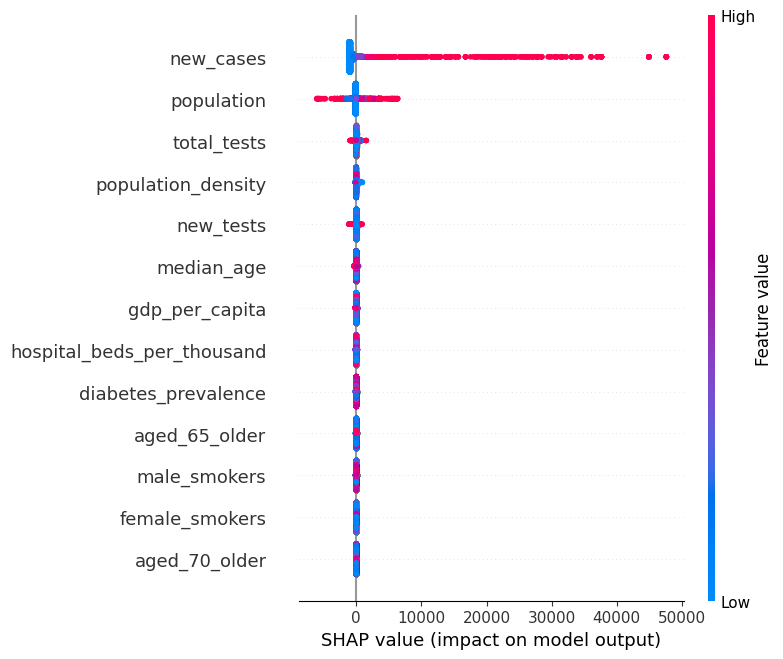

In [5]:
explainer = shap.Explainer(covid_future_cases_predictive_model)
shap_values_LGBM = explainer(X_train)

shap.summary_plot(shap_values_LGBM)

#shap.summary_plot(
#    shap_values_LGBM, X_train, 
#    feature_names=X_train.columns, plot_type="bar"
#)


### Deductions from Summary Plot shown above

New cases, population, total tests and new tests are the features that impact the COVID future cases prediction most.New cases is the one main feature that has impact on future covid prediction.
1) As new cases increase (Red indicates high, blue low), the probability of future cases also increases
2) Polupation increase increases the probablity of future cases as well.
3) the same explaination made in 1) and 2) can be extended to total tests and new tests.

The rest of the features median age, population density,GDP,hospital beds,gender, smoking status does not have significant impact on prediction.

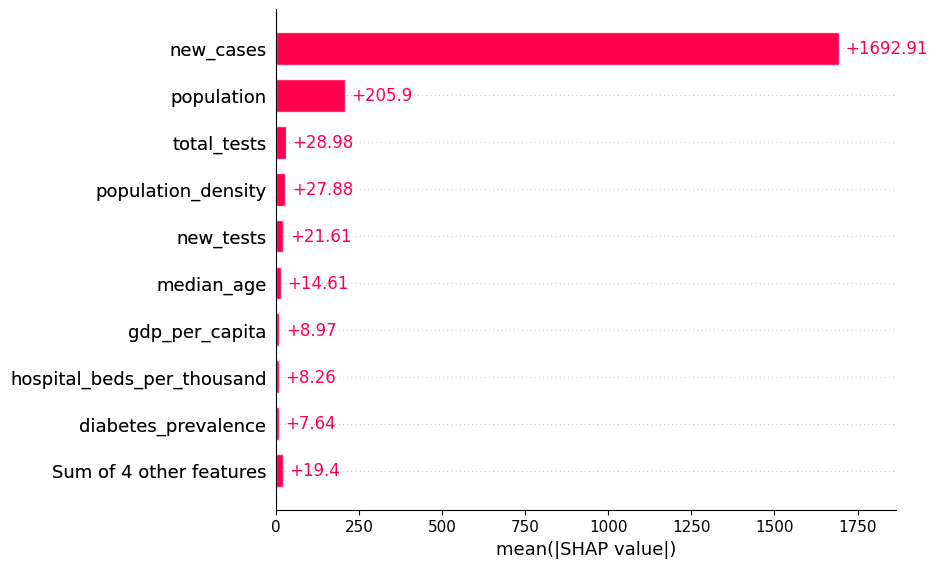

In [6]:
shap.plots.bar(shap_values_LGBM)

 - Create a SHAP dependence plot to show how the features 'new_cases' and 'population' interact
 - Does a relationship exist here? 

#### 'new_cases' and 'population' features are highly correlated. Greater the popolation higher is the number of new cases

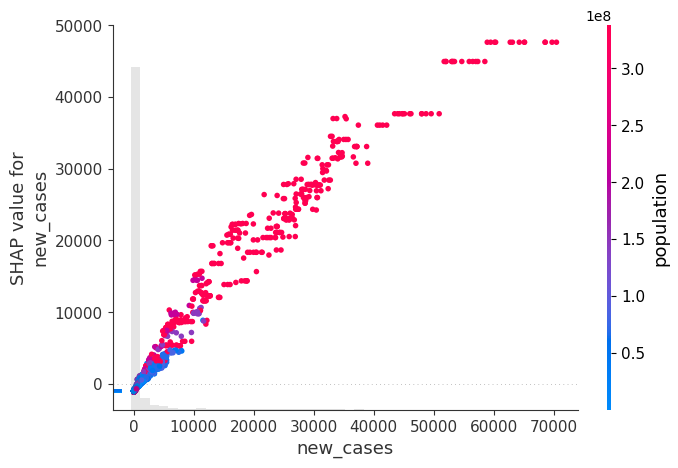

In [7]:
#Plot 1: new_cases,population
shap.plots.scatter(shap_values_LGBM[:,"new_cases"],
                   color=shap_values_LGBM[:,"population"])

 - Create a SHAP dependence plot to show how the features 'new_tests' and 'population' interact
 - Does a relationship exist here? How can the numbers of new tests influence cases in the future
 - Is this an example of unwanted bias, where countries that test more have higher predicted cases in the future?

####  Features new_tests and population are not correlated. We do see increase in number of new tests conducted as population increases. From summary plot we did see that increase in 'new_tests' might  increase  prediction,although this might not be significant. We need more data/evidence to claim that unwnted bias exists,where countries that test more have higher predicted cases in the future. 

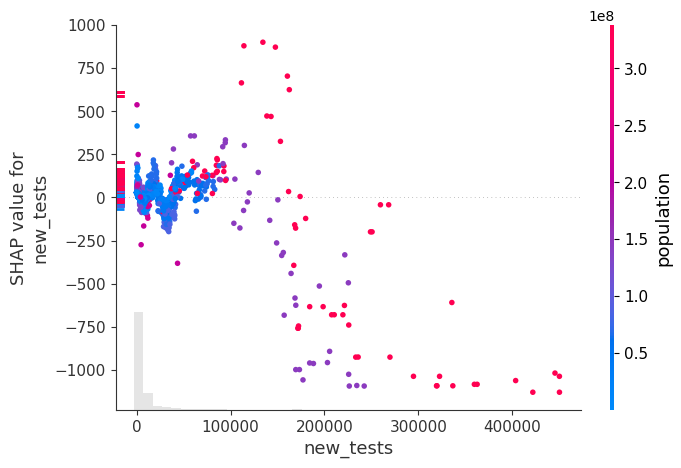

In [8]:
#Plot 2: new_tests,population
shap.plots.scatter(shap_values_LGBM[:,"new_tests"],
                   color=shap_values_LGBM[:,"population"])

 - Create a SHAP summary plot to understand what the model's reasoning is on a global level for the visualization set

#### Looks like for visualization category, we see that increase in number of new_cases and population have the highest impact on target prediction.Age,gender and smoking status have little to no impact on prediction. Polpulation_density lowers the prediction with increase in value.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


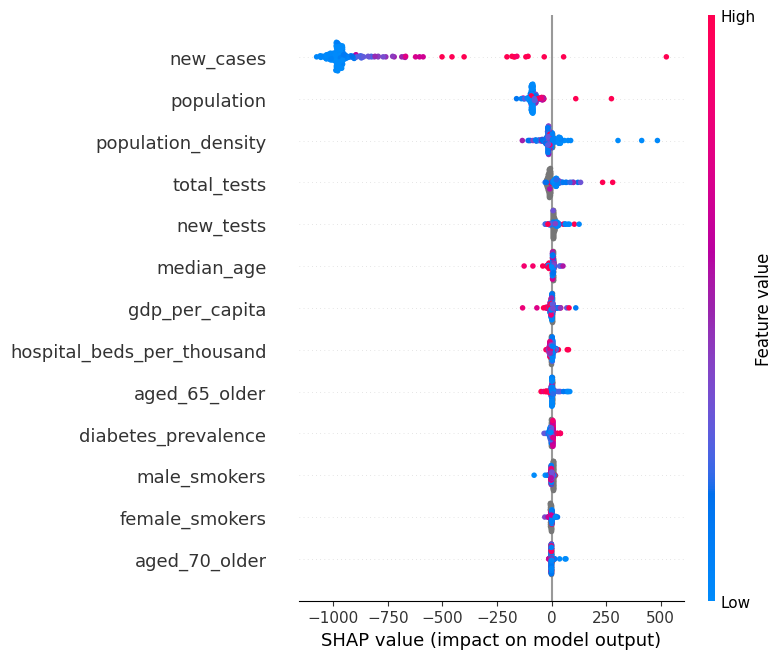

In [9]:
explainer_vis = shap.Explainer(covid_future_cases_predictive_model)
shap_values_LGBM_vis = explainer_vis(X_visualization)

shap.summary_plot(shap_values_LGBM_vis)


 - Using shap.force_plot on only one row of data, explain the model's reasoning for prediction on that row.
 - In general, the base value is the expected value for the whole training set. If the model's output is lower, it means that the 
 downward pushing forces (blue forces) are stronger than the upward pushing forces (red forces)

#### We see that the model's output is lower for row 6 because the downward pushing forces (blue) which are new_cases (mainly) and population are stronger. This kind of make sense since we did see the new_Cases and popluation have the maximum impact on prediction.

In [13]:
shap.plots.force(shap_values_LGBM[6]) 


 - Use shap.force_plot on the entire visualization set to show the model's reasoning.
 - Note that this force plot, over a whole dataset, is simply a large number of individual force plots which have been flipped and pushed together 
 - Confirm that the underlying story matches the underlying story and important features from the summary plots.
 - In general, the base value is the expected value for the whole training set. If the model's output is lower, it means that the 
 downward pushing forces (blue forces) are stronger than the upward pushing forces (red forces)
 - Explain what patterns shown in this plot are outliers. What are the strongest forces for these outliers?

#### This was a bit confusing to me, so I am going to say what i concluded from the plot but it could be wrong. The outliers are located at the right most end of the plotting since the plotting is grouped by similiar sample order.



In [11]:
print(len(shap_values_LGBM))
# aggregated force plot taking first 5000 cases having trouble with aggregation of 11293 rows
shap.plots.force(shap_values_LGBM[0:5000])

11293


shap.plots.force is slow for many thousands of rows, try subsampling your data.


 - By clicking on a part of the force plot which represents an outlier, obtain its original index. 
 - Then, inspect its individual force plot.
 - Consider if the GBM's reasoning makes sense for this outlier

#### 4346 is an outlier, we see that there are high number of new_cases driving the prediction up this is leading to a large deviation in prediction (49,507)  from base value which is 1071. To me it makes sense GBM.

In [20]:
shap.plots.force(shap_values_LGBM[4346]) #3171,4346



 - Use shap.decision_plot to plot SHAP values for the first 20 examples in the visualization set.
 - Often users will find decision plots easier to interpret than force plots over a whole dataset. They both aim to visualize the same thing, but
 force plots are interactive while decision plots are static


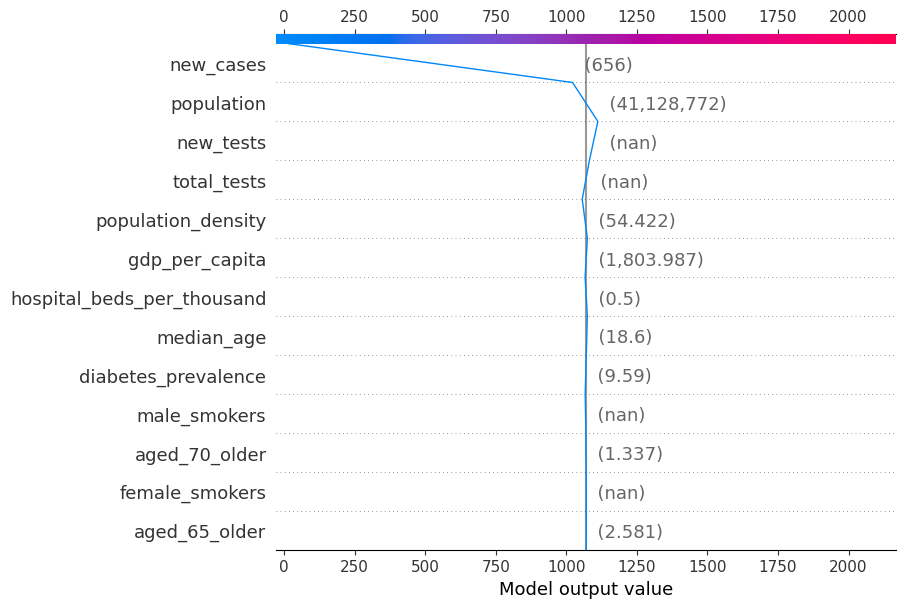

In [38]:
import warnings

select = range(20)
features = X_visualization.iloc[select]
features_display = X_visualization.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer_vis.shap_values(features)[1]
    shap_interaction_values = explainer_vis.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]
    
shap.decision_plot(explainer_vis.expected_value, shap_values, features_display)


## Complete the deliverable

The final deliverables are the force plots and the decision plot. Save these for future use.